In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# For reading and processing images
import os
import cv2
import imageio
from PIL import Image

# For visualizations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow import keras

### Load data


In [3]:
# Thay bằng đường dẫn đến mask và image
# Nhớ là phải lọc ảnh trước, vì có những ảnh không có mask (đã viết file helper trong project để xử lý vấn đề này)

# images_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256-notmark/images'
# masks_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256-notmark/masks'

# images_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256/images'
# masks_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256/masks'

images_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images'
masks_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/masks'

In [4]:
list_image_name = os.listdir(images_folder)
list_masks_name = os.listdir(masks_folder) 

print(list_image_name)
print(len(list_image_name))

print(list_masks_name)
print(len(list_masks_name))

['nt-0.jpg', 'nt-21.jpg', 'nt-15.jpg', 'nt-28.jpg', 'nt-7.jpg', 'nt-3.jpg', 'nt-25.jpg', 'nt-9.jpg', 'nt-11.jpg', 'nt-13.jpg', 'nt-2.jpg', 'nt-26.jpg', 'nt-16.jpg', 'nt-23.jpg', 'nt-24.jpg', 'nt-19.jpg', 'nt-1.jpg', 'nt-30.jpg', 'nt-29.jpg', 'nt-4.jpg', 'nt-31.jpg', 'nt-5.jpg', 'nt-27.jpg', 'nt-14.jpg', 'nt-6.jpg', 'nt-17.jpg', 'nt-18.jpg', 'nt-20.jpg', 'nt-22.jpg', 'nt-8.jpg', 'nt-12.jpg', 'nt-10.jpg', 'nt-61.jpg', 'nt-50.jpg', 'nt-60.jpg', 'nt-68.jpg', 'nt-52.jpg', 'nt-71.jpg', 'nt-79.jpg', 'nt-67.jpg', 'nt-54.jpg', 'nt-45.jpg', 'nt-51.jpg', 'nt-75.jpg', 'nt-66.jpg', 'nt-63.jpg', 'nt-49.jpg', 'nt-46.jpg', 'nt-86.jpg', 'nt-35.jpg', 'nt-55.jpg', 'nt-83.jpg', 'nt-32.jpg', 'nt-70.jpg', 'nt-53.jpg', 'nt-33.jpg', 'nt-90.jpg', 'nt-40.jpg', 'nt-76.jpg', 'nt-74.jpg', 'nt-44.jpg', 'nt-91.jpg', 'nt-82.jpg', 'nt-57.jpg', 'nt-64.jpg', 'nt-89.jpg', 'nt-80.jpg', 'nt-42.jpg', 'nt-69.jpg', 'nt-88.jpg', 'nt-37.jpg', 'nt-85.jpg', 'nt-87.jpg', 'nt-77.jpg', 'nt-41.jpg', 'nt-48.jpg', 'nt-36.jpg', 'nt-81.j

In [5]:
def load_path(imgs_dir, masks_dir):
  images = []
  masks = []

  for file in os.listdir(images_folder):
    images.append(os.path.join(images_folder, file))

  for file in os.listdir(masks_folder):
    masks.append(os.path.join(masks_folder, file))

  return images, masks

In [6]:
list_images_paths, list_masks_paths = load_path(images_folder, masks_folder)

In [7]:
list_images_paths.sort()
print(list_images_paths)
print(len(list_images_paths))

list_masks_paths.sort()
print(list_masks_paths)
print(len(list_masks_paths))

['/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-0.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-1.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-10.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-100.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-101.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-102.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-103.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-104.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-105.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-106.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-107.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-108.jpg', '/content/gdrive/MyDrive/nt-data

In [8]:
def show_img_with_mask(idx, images, masks):
  img = plt.imread(images[idx])
  mask = plt.imread(masks[idx])
  pair = np.concatenate((img, mask), axis=1)
  plt.figure(figsize=(15,20))
  plt.imshow(pair, cmap='gray')

In [9]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm thử
train_image_paths, test_image_paths = train_test_split(list_images_paths, test_size=0.2, random_state=30)

print(train_image_paths)
print(len(train_image_paths))

print(test_image_paths)
print(len(test_image_paths))

['/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-rotation-18.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-167.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-brightness-40.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-flip-227.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-99.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-40.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-brightness-73.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-flip-68.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-228.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-brightness-130.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-191.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/i

In [10]:
def get_masks_corres(images_list):
  masks_list = []
  for i in range(0, len(images_list)):
    temp_list = images_list[i].split('/')
    temp_list[-2] = 'masks'
    masks_list.append('/'.join(temp_list))
  return masks_list

In [11]:
train_mask_paths = get_masks_corres(train_image_paths)
test_mask_paths = get_masks_corres(test_image_paths)

print(train_image_paths)
print(train_mask_paths)
print(len(train_mask_paths))

print(test_image_paths)
print(test_mask_paths)
print(len(test_mask_paths))

['/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-rotation-18.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-167.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-brightness-40.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-flip-227.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-99.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-40.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-brightness-73.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-flip-68.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-228.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-brightness-130.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images/nt-191.jpg', '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/i

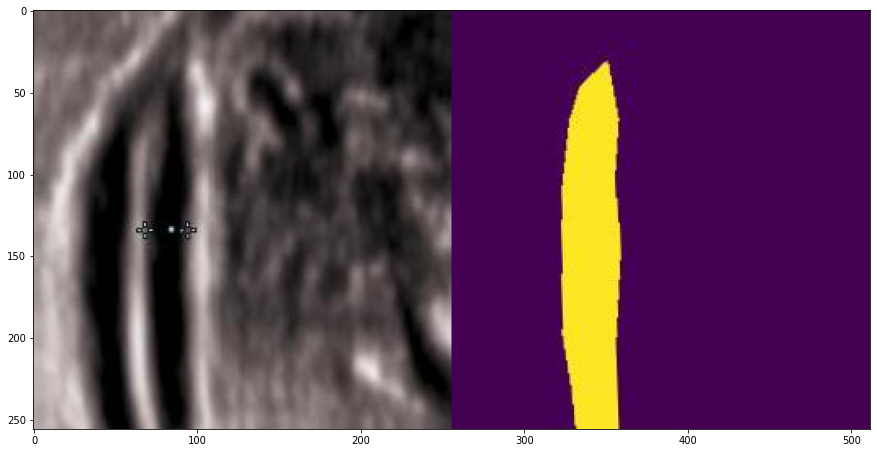

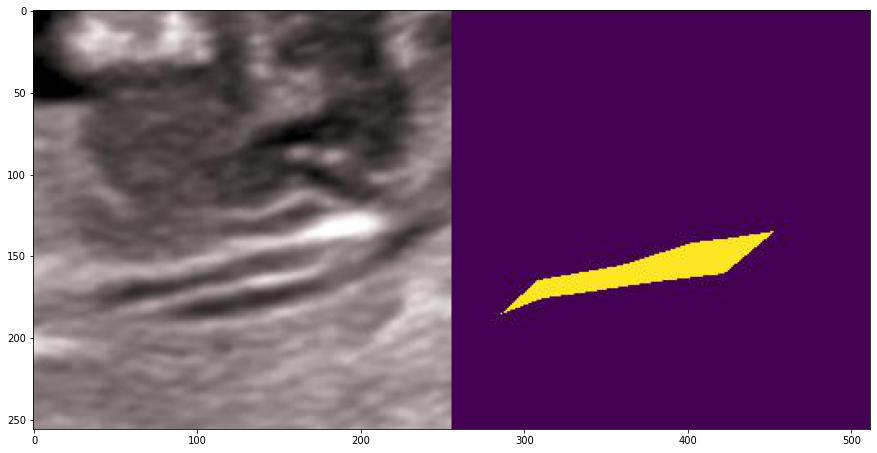

In [12]:
for i in range(2):
  show_img_with_mask(i, train_image_paths, train_mask_paths)

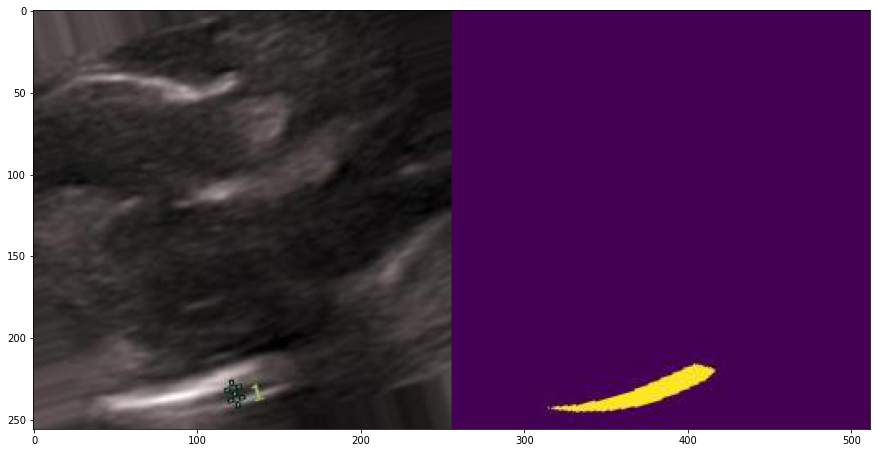

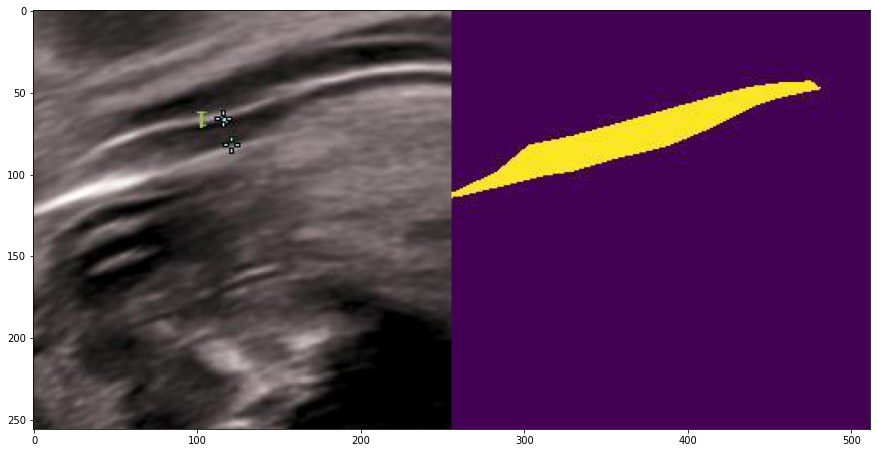

In [13]:
for i in range(2):
  show_img_with_mask(i, test_image_paths, test_mask_paths)

### Preprocessing data

In [14]:
"""
Đầu vào là ảnh gốc có 3 kênh màu
Ảnh mask tương ứng chỉ để 1 kênh màu
"""

target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]

def PreprocessData(image_list, mask_list, mode="train"):
    # Cấu hình input cho ảnh gốc và mask tương ứng
    number_of_example = len(image_list)
    image_height, image_width, image_channels = target_shape_img
    mask_height, mask_width, mask_channels = target_shape_mask

    # Mảng để lưu trữ các ảnh và mask dưới dạng numpy array
    images = np.zeros((number_of_example, image_height, image_width, image_channels), dtype=np.float32)
    masks = np.zeros((number_of_example, mask_height, mask_width, mask_channels), dtype=np.int32)

    print('----------- Processing {0} images --------------'.format(mode))
    for (index, img) in enumerate(image_list):
        single_img = Image.open(img).convert('RGB')
        single_img = single_img.resize((image_height, image_width))
        single_img = np.reshape(single_img, (image_height, image_width, image_channels))
        single_img = single_img/256.
        images[index] = single_img
    print('----------- Processing {0} images done! --------------'.format(mode))

    print('\n')
    
    print('----------- Processing {0} mask --------------'.format(mode))
    for (index, mask) in enumerate(mask_list):
        single_mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        single_mask = cv2.resize(single_mask, dsize=(mask_height, mask_width), interpolation=cv2.INTER_NEAREST)
        single_mask = np.asarray(single_mask)
        single_mask = single_mask[..., tf.newaxis]
        single_mask = np.reshape(single_mask, (mask_height, mask_width, mask_channels))
        single_mask = np.round(single_mask/255)
        single_mask = single_mask.astype(int)
        masks[index] = single_mask
    print('----------- Processing {0} mask done! --------------'.format(mode))
    
    print('\n')
    
    return images, masks

In [15]:
# Process data using apt helper function
img_train, mask_train = PreprocessData(train_image_paths, train_mask_paths)
img_test, mask_test = PreprocessData(test_image_paths, test_mask_paths, "test")

# train
print("Train img Shape:", img_train.shape)
print("Train mask shape:", mask_train.shape)

# test
print("Test img Shape:", img_test.shape)
print("Mask img shape:", mask_test.shape)

# There are 2 classes
print(np.unique(mask_train))
print(np.unique(mask_test))

----------- Processing train images --------------
----------- Processing train images done! --------------


----------- Processing train mask --------------
----------- Processing train mask done! --------------


----------- Processing test images --------------
----------- Processing test images done! --------------


----------- Processing test mask --------------
----------- Processing test mask done! --------------


Train img Shape: (761, 256, 256, 3)
Train mask shape: (761, 256, 256, 1)
Test img Shape: (191, 256, 256, 3)
Mask img shape: (191, 256, 256, 1)
[0 1]
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

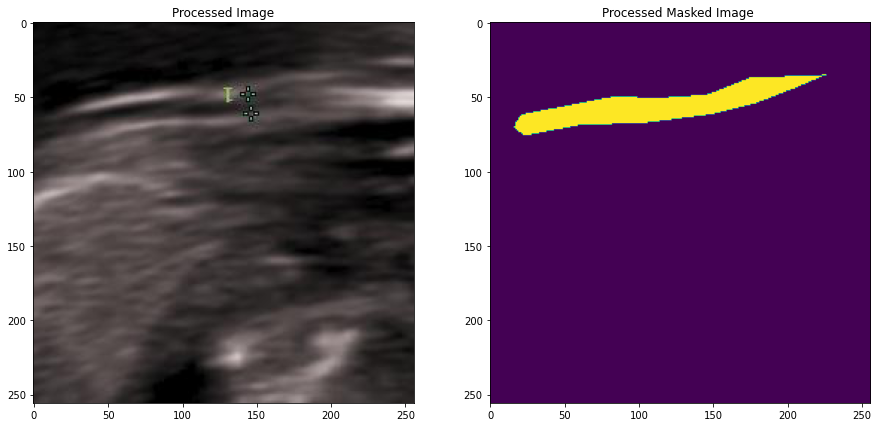

In [16]:
 # Visualize the output
index_test = 145
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_train[index_test])
arr[0].set_title('Processed Image')
arr[1].imshow(mask_train[index_test, :, :, 0])
arr[1].set_title('Processed Masked Image ')

Text(0.5, 1.0, 'Processed Masked Image ')

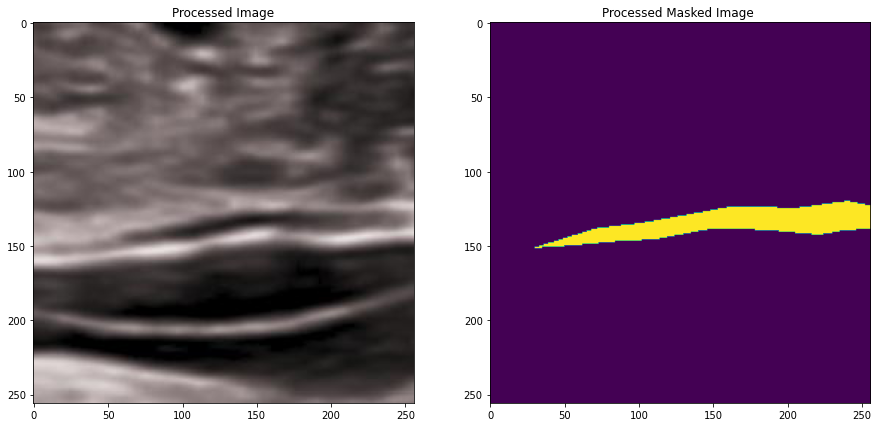

In [17]:
# Visualize the output
index_test = 10
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_test[index_test])
arr[0].set_title('Processed Image')
arr[1].imshow(mask_test[index_test][:, :, 0])
arr[1].set_title('Processed Masked Image ')

In [18]:
input_size = (256, 256, 3)
n_filters = 64
n_classes = 2

In [19]:
def EncoderChildBlock(inputs, n_filters=n_filters, dropout_prob=0.3, max_pooling=True):
    # kernel_initializer để tránh việc vanishing gradients.
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)

    # Chuẩn hóa các giá trị đầu ra trên mỗi layer về dạng zero-mean
    conv = BatchNormalization()(conv, training=False)

    # Dropout  cho trường hợp overfitting
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    #  Max pooling với cửa sổ là 2x2
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(conv)
    else:
        next_layer = conv

    # skip_connection đưa đầu ra sang phần decoder để huấn luyện tương ứng tránh mất mát đặc trưng.
    skip_connection = conv

    return next_layer, skip_connection

In [20]:
def DecoderChildBlock(prev_layer_input, skip_layer_input, n_filters=n_filters):
    # Transpose convolution để tăng kích thước ảnh và giảm lượng kênh màu (đặc trưng) xuống một nửa
    up = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(prev_layer_input)

    # gộp 2 layer với nhau tránh mất mát thông tin
    merge = concatenate([up, skip_layer_input], axis=3)

    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    return conv

In [21]:
def UNetCompiled(input_size=input_size, n_filters=n_filters, n_classes=n_classes):

    inputs = Input(input_size)

    # n_filters tăng dần để giảm kích thước các tensor và tăng gấp đôi lượng kênh màu
    cblock1 = EncoderChildBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderChildBlock(cblock1[0], n_filters*2, dropout_prob=0.3, max_pooling=True)
    cblock3 = EncoderChildBlock(cblock2[0], n_filters*4, dropout_prob=0.3, max_pooling=True)
    cblock4 = EncoderChildBlock(cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)

    # Khối giữa
    cblock5 = EncoderChildBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Khối decoder, sử dụng các layer bao gồm nhiều khối ConvolutionTranspose và concatenate để gộp đặc trưng từ phần encoder.
    # Giảm kích thước kênh màu và tăng kích thước ảnh.
    ublock6 = DecoderChildBlock(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = DecoderChildBlock(ublock6, cblock3[1], n_filters*4)
    ublock8 = DecoderChildBlock(ublock7, cblock2[1], n_filters*2)
    ublock9 = DecoderChildBlock(ublock8, cblock1[1], n_filters)

    # Layer output bên phần decoder
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)

    # Kích thước của kernel là 1x1 để lấy ảnh đầu ra có kích thước giống với ảnh ban đầu.
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [22]:
# Gán lại dữ liệu
X_train, X_valid, y_train, y_valid = img_train, img_test, mask_train, mask_test

# Compile the model
unet = UNetCompiled()

# Check the summary
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [23]:
# Cấu hình batch_size, epochs, lr, optimizer
batch_size = 32
epochs = 50
optimizer = Adam(learning_rate=1e-5)

# Hàm mất mát CrossEntropyLoss.
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile và chạy mô hình
unet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Run
results = unet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/50
24/24 [==============================] - 138s 4s/step - loss: 0.4797 - accuracy: 0.8925 - val_loss: 0.3419 - val_accuracy: 0.9428
Epoch 2/50
24/24 [==============================] - 53s 2s/step - loss: 0.3173 - accuracy: 0.9394 - val_loss: 0.3451 - val_accuracy: 0.9443
Epoch 3/50
24/24 [==============================] - 54s 2s/step - loss: 0.2958 - accuracy: 0.9415 - val_loss: 0.3291 - val_accuracy: 0.9451
Epoch 4/50
24/24 [==============================] - 54s 2s/step - loss: 0.2717 - accuracy: 0.9424 - val_loss: 0.3165 - val_accuracy: 0.9458
Epoch 5/50
24/24 [==============================] - 54s 2s/step - loss: 0.2350 - accuracy: 0.9433 - val_loss: 0.2787 - val_accuracy: 0.9462
Epoch 6/50
24/24 [==============================] - 54s 2s/step - loss: 0.2077 - accuracy: 0.9440 - val_loss: 0.2857 - val_accuracy: 0.9463
Epoch 7/50
24/24 [==============================] - 54s 2s/step - loss: 0.1917 - accuracy: 0.9444 - val_loss: 0.2978 - val_accuracy: 0.9458
Epoch 8/50
24/24 [=

In [ ]:
unet.save('unet-8-256x256-25ep-94%.h5')

In [24]:
def unet_predict(index_of_test):
  img = img_test[index_of_test][np.newaxis, ...]
  pred_y = unet.predict(img)
  pred_mask = tf.argmax(pred_y[0], axis=-1)
  return pred_mask

Text(0.5, 1.0, 'Processed predict mask ')

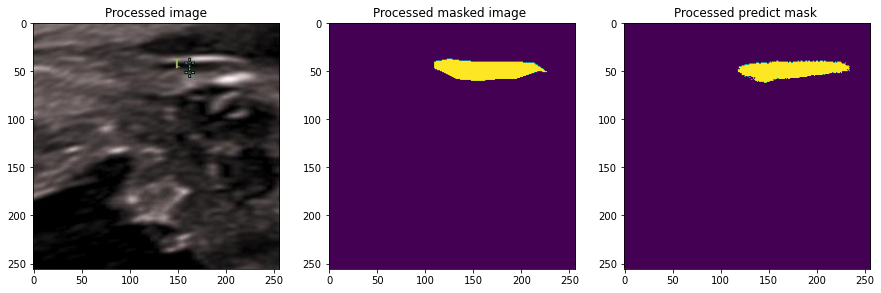

In [29]:
index_test = 60
pred_mask = unet_predict(index_test)

_, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(img_test[index_test])
arr[0].set_title('Processed image')
arr[1].imshow(mask_test[index_test][:, :, 0])
arr[1].set_title('Processed masked image ')
arr[2].imshow(pred_mask)
arr[2].set_title('Processed predict mask ')